# Gaussian Processes in 1 Dimension



In [16]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

__author__ = "mjp"
__version__ = "0.0.1"
__status__ = "development"

__copyright__ = "Copyright 2016, JHU/APL"
__license__ = "Apache, Version 2.0"

import os, csv

import numpy as np
import pylab as plt
from mpl_toolkits.mplot3d import axes3d, art3d

from helpers import *

import GPy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Helper functions

def vec_to_mat(v):
    """Reshapes a vector of dimension (n,) to have dimension (n,1).
    This is because some GPy methods check ndim(v)==2."""
    return v if v.ndim >= 2 else v[:,np.newaxis]


def scale_input(X):
    "Maps values to unit hypercube."
    xMin = np.min(X, axis=0)    
    xMax = np.max(X, axis=0)
    return (X - xMin) / (xMax - xMin)


def normalize_obs(Y, mu=None, sigma=None):
    """ Rescales observations to have zero mean and unit variance.
    """
    if not mu:
        mu = np.mean(Y, axis=0)
    if not sigma:
        sigma = np.std(Y, axis=0)
    Z = (Y - mu) / sigma
    return Z, mu, sigma

In [13]:
inDir = os.path.join('..', 'data')
inFile = os.path.join(inDir, 'NIST_randomized_metal_no1.csv')
Z = load_data(inFile)

# extract data of interest
# The measured variables wear hats.
x = Z[:,0];  xHat = Z[:,1]
y = Z[:,2];  yHat = Z[:,3]
d = Z[:,4];  dHat = Z[:,5]
z = Z[:,6];  zHat = Z[:,7]

r, theta = cart2polar(x,y)
rHat, thetaHat = cart2polar(xHat, yHat)

# Apply a rotation to the pin locations.
alpha = np.pi/1100.0 
rotClockwise = np.array([[np.cos(alpha), np.sin(alpha)], [-np.sin(alpha), np.cos(alpha)]])
print('Rotating observed pin locations about z axis')

# Variables with tildes are the rotated versions of the hats (observations)
obsHat = np.vstack((xHat, yHat))
obsTilde = np.dot(rotClockwise, obsHat)
xTilde = obsTilde[0,:]
yTilde = obsTilde[1,:]

#plot_xy_err_2d(theta, xTilde-x, yTilde-y, xLabel='theta (nominal)')
#plot_xy_err_2d(r, xTilde-x, yTilde-y, xLabel='r (nominal)')

Rotating observed pin locations about z axis


(50, 1) 0.0 1.0
(50,) -161.574860392 111.667506837


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x10d7cf390>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x10d634290>],
  [<matplotlib.lines.Line2D at 0x10d7c27d0>]]}

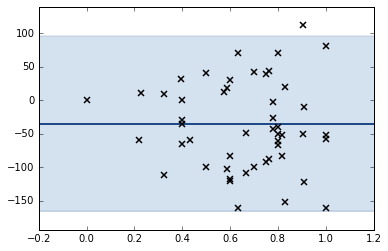

In [35]:
# X := GP input domain
X = scale_input(r);   # map r to [0,1]
print X.shape, np.min(X), np.max(X)

# obs := response variable
obs, mu, sigma = normalize_obs(xTilde - x)    
print obs.shape, np.min(obs), np.max(obs)

# For now, we use a generic kernel.
# TODO: cross-validation to select kernel.
ker = GPy.kern.Matern52(X.shape[1], ARD=True, lengthscale=.02)
model = GPy.models.GPRegression(X, vec_to_mat(obs), ker)
model.optimize(messages=True, max_f_eval=1000)

model.plot()
